In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["source_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)
source_scaling = config["source_scaling"]

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/LensSR/Simulations/data_model_1/',['no_sub_noise'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)
s_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["s_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.LensingLoss(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG,device=device,alpha=alpha, resolution=resolution, BATCH_SIZE=BATCH_SIZE, source_scaling=source_scaling).to(device)

opt = torch.optim.Adam(params=s_model.parameters(),lr=LR)
total_params = sum(p.numel() for p in s_model.parameters())
print(f"Number of parameters: {total_params}x2")

Number of parameters: 899843x2


In [6]:
def give_random_image(dataset, model1, model2, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    t1 = model1(t.float().to(device)).cpu().detach()
    t2 = model2(t.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3, image4 = phy_loss.get_samples(t1.to(device))
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2, Image.fromarray(image3.cpu().numpy()[0][0]*255), Image.fromarray(image4.cpu().numpy()[0][0]*255))

def show_random_image(image_tuple):
    image0, image1, image2, image3, image4 = image_tuple[0], image_tuple[1], image_tuple[2], image_tuple[3], image_tuple[4]
    plot, axes = plt.subplots(1,5)
    plot.set_size_inches(30,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[3].imshow(image3)
    axes[4].imshow(image4)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Source_network")
    axes[3].set_title("Source_regenerated")
    axes[4].set_title("Source_true")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))

<All keys matched successfully>

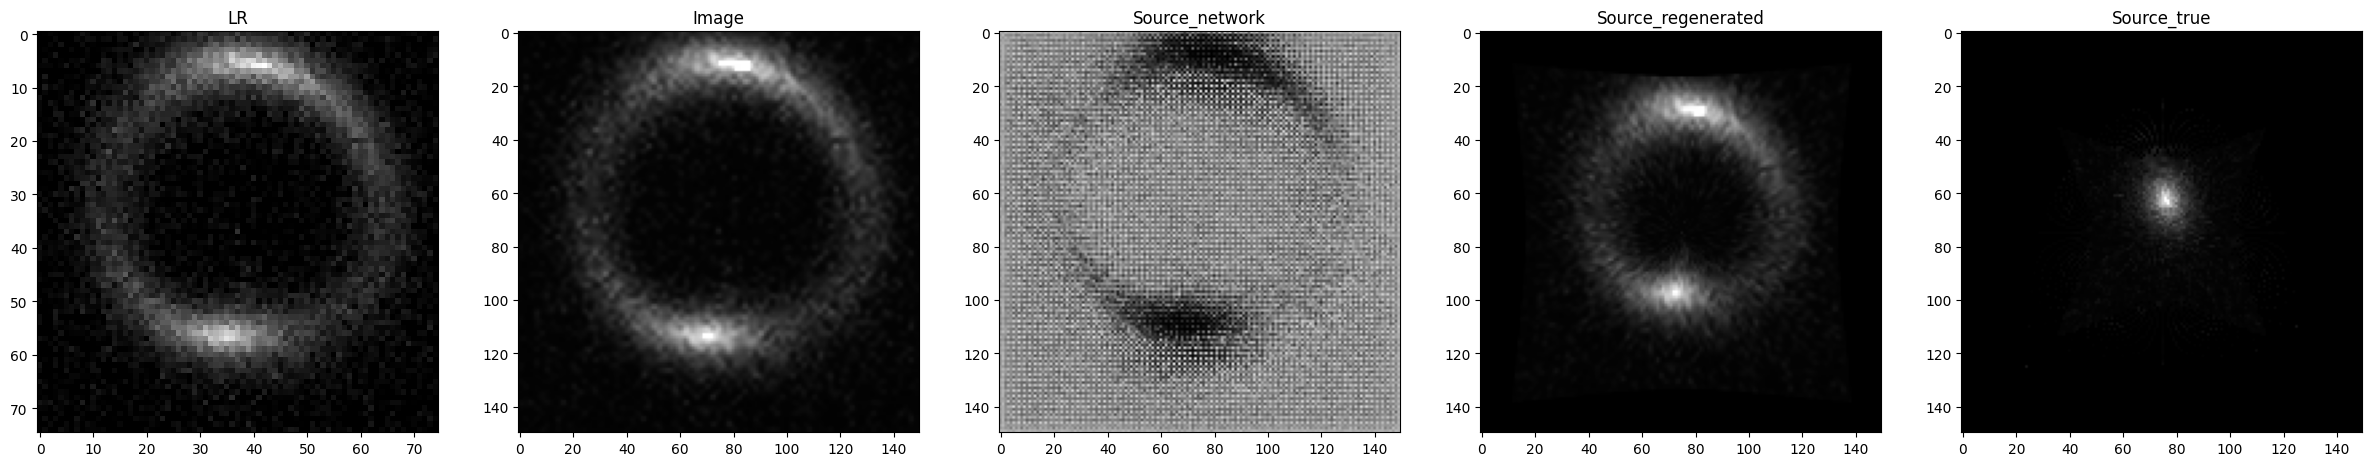

In [8]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))

In [9]:
best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[]}
for epoch in range(EPOCHS):
    losses = []
    i_model.eval()
    s_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        loss = phy_loss(source, image, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    i_model.eval()
    s_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        source = s_model(x)
        # k_tensor = k_model(x)
        val_loss = phy_loss(source, image, x)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = s_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 800/800 [01:05<00:00, 12.26it/s]


Training at epoch 1/50: 0.2923784863576293 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:05<00:00, 33.88it/s]


Validation at epoch 1/50: 0.2760144168138504 at LR=0.0001


Training epoch 2: 100%|██████████| 800/800 [01:05<00:00, 12.17it/s]


Training at epoch 2/50: 0.25409202607348563 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:05<00:00, 33.65it/s]


Validation at epoch 2/50: 0.23491836503148078 at LR=0.0001


Training epoch 3: 100%|██████████| 800/800 [01:05<00:00, 12.13it/s]


Training at epoch 3/50: 0.22525691486895083 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:05<00:00, 33.61it/s]


Validation at epoch 3/50: 0.2217600354552269 at LR=0.0001


Training epoch 4: 100%|██████████| 800/800 [01:06<00:00, 12.11it/s]


Training at epoch 4/50: 0.19975698238238693 at LR=0.0001


Validation epoch 4: 100%|██████████| 200/200 [00:05<00:00, 33.77it/s]


Validation at epoch 4/50: 0.1808409158885479 at LR=0.0001


Training epoch 5: 100%|██████████| 800/800 [01:06<00:00, 12.10it/s]


Training at epoch 5/50: 0.17668024575337768 at LR=0.0001


Validation epoch 5: 100%|██████████| 200/200 [00:05<00:00, 33.73it/s]


Validation at epoch 5/50: 0.16673424877226353 at LR=0.0001


Training epoch 6: 100%|██████████| 800/800 [01:06<00:00, 12.06it/s]


Training at epoch 6/50: 0.1560988129582256 at LR=0.0001


Validation epoch 6: 100%|██████████| 200/200 [00:05<00:00, 33.71it/s]


Validation at epoch 6/50: 0.14291836082935333 at LR=0.0001


Training epoch 7: 100%|██████████| 800/800 [01:06<00:00, 12.07it/s]


Training at epoch 7/50: 0.13762010996229945 at LR=0.0001


Validation epoch 7: 100%|██████████| 200/200 [00:05<00:00, 33.72it/s]


Validation at epoch 7/50: 0.1315725541859865 at LR=0.0001


Training epoch 8: 100%|██████████| 800/800 [01:06<00:00, 12.05it/s]


Training at epoch 8/50: 0.12099072081968189 at LR=0.0001


Validation epoch 8: 100%|██████████| 200/200 [00:05<00:00, 33.42it/s]


Validation at epoch 8/50: 0.11218057122081518 at LR=0.0001


Training epoch 9: 100%|██████████| 800/800 [01:06<00:00, 12.06it/s]


Training at epoch 9/50: 0.10621685953810811 at LR=0.0001


Validation epoch 9: 100%|██████████| 200/200 [00:05<00:00, 33.78it/s]


Validation at epoch 9/50: 0.10011543162167072 at LR=0.0001


Training epoch 10: 100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


Training at epoch 10/50: 0.09283260761760176 at LR=0.0001


Validation epoch 10: 100%|██████████| 200/200 [00:05<00:00, 33.66it/s]


Validation at epoch 10/50: 0.08377655178308487 at LR=0.0001


Training epoch 11: 100%|██████████| 800/800 [01:06<00:00, 12.05it/s]


Training at epoch 11/50: 0.08104974654503166 at LR=0.0001


Validation epoch 11: 100%|██████████| 200/200 [00:06<00:00, 33.29it/s]


Validation at epoch 11/50: 0.08073267575353384 at LR=0.0001


Training epoch 12: 100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


Training at epoch 12/50: 0.07055531429126859 at LR=0.0001


Validation epoch 12: 100%|██████████| 200/200 [00:05<00:00, 33.68it/s]


Validation at epoch 12/50: 0.062379180695861576 at LR=0.0001


Training epoch 13: 100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


Training at epoch 13/50: 0.06131301324814558 at LR=0.0001


Validation epoch 13: 100%|██████████| 200/200 [00:05<00:00, 33.59it/s]


Validation at epoch 13/50: 0.06353152437135577 at LR=0.0001


Training epoch 14: 100%|██████████| 800/800 [01:06<00:00, 12.03it/s]


Training at epoch 14/50: 0.05306565646082163 at LR=0.0001


Validation epoch 14: 100%|██████████| 200/200 [00:05<00:00, 33.35it/s]


Validation at epoch 14/50: 0.054891792815178635 at LR=0.0001


Training epoch 15: 100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


Training at epoch 15/50: 0.045856783143244685 at LR=0.0001


Validation epoch 15: 100%|██████████| 200/200 [00:05<00:00, 33.59it/s]


Validation at epoch 15/50: 0.04434713818132877 at LR=0.0001


Training epoch 16: 100%|██████████| 800/800 [01:06<00:00, 12.03it/s]


Training at epoch 16/50: 0.03955682298401371 at LR=0.0001


Validation epoch 16: 100%|██████████| 200/200 [00:05<00:00, 33.59it/s]


Validation at epoch 16/50: 0.039381721932440994 at LR=0.0001


Training epoch 17: 100%|██████████| 800/800 [01:06<00:00, 12.02it/s]


Training at epoch 17/50: 0.03403083710698411 at LR=0.0001


Validation epoch 17: 100%|██████████| 200/200 [00:05<00:00, 33.46it/s]


Validation at epoch 17/50: 0.032529565254226324 at LR=0.0001


Training epoch 18: 100%|██████████| 800/800 [01:06<00:00, 12.03it/s]


Training at epoch 18/50: 0.029179690543096513 at LR=0.0001


Validation epoch 18: 100%|██████████| 200/200 [00:05<00:00, 33.43it/s]


Validation at epoch 18/50: 0.024648258723318578 at LR=0.0001


Training epoch 19: 100%|██████████| 800/800 [01:06<00:00, 12.04it/s]


Training at epoch 19/50: 0.024962558487895876 at LR=0.0001


Validation epoch 19: 100%|██████████| 200/200 [00:05<00:00, 33.47it/s]


Validation at epoch 19/50: 0.019773684283718465 at LR=0.0001


Training epoch 20: 100%|██████████| 800/800 [01:06<00:00, 12.03it/s]


Training at epoch 20/50: 0.021342436592094602 at LR=0.0001


Validation epoch 20: 100%|██████████| 200/200 [00:06<00:00, 33.30it/s]


Validation at epoch 20/50: 0.01641776826232672 at LR=0.0001


Training epoch 21: 100%|██████████| 800/800 [01:06<00:00, 12.01it/s]


Training at epoch 21/50: 0.01818825287045911 at LR=0.0001


Validation epoch 21: 100%|██████████| 200/200 [00:06<00:00, 33.27it/s]


Validation at epoch 21/50: 0.01760239670984447 at LR=0.0001


Training epoch 22: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 22/50: 0.015460704932920635 at LR=0.0001


Validation epoch 22: 100%|██████████| 200/200 [00:06<00:00, 33.11it/s]


Validation at epoch 22/50: 0.019193372623994946 at LR=0.0001


Training epoch 23: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 23/50: 0.013154620184213855 at LR=0.0001


Validation epoch 23: 100%|██████████| 200/200 [00:05<00:00, 33.41it/s]


Validation at epoch 23/50: 0.012655820776708425 at LR=0.0001


Training epoch 24: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 24/50: 0.011144657552940772 at LR=0.0001


Validation epoch 24: 100%|██████████| 200/200 [00:05<00:00, 33.58it/s]


Validation at epoch 24/50: 0.008960937256924808 at LR=0.0001


Training epoch 25: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 25/50: 0.009448711609002203 at LR=0.0001


Validation epoch 25: 100%|██████████| 200/200 [00:06<00:00, 33.30it/s]


Validation at epoch 25/50: 0.008889404661022126 at LR=0.0001


Training epoch 26: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 26/50: 0.007994598234072328 at LR=0.0001


Validation epoch 26: 100%|██████████| 200/200 [00:06<00:00, 33.30it/s]


Validation at epoch 26/50: 0.008571876320056617 at LR=0.0001


Training epoch 27: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 27/50: 0.0067823212913936 at LR=0.0001


Validation epoch 27: 100%|██████████| 200/200 [00:05<00:00, 33.45it/s]


Validation at epoch 27/50: 0.006768398680724204 at LR=0.0001


Training epoch 28: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 28/50: 0.005749585272569675 at LR=0.0001


Validation epoch 28: 100%|██████████| 200/200 [00:05<00:00, 33.34it/s]


Validation at epoch 28/50: 0.004903718803543598 at LR=0.0001


Training epoch 29: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 29/50: 0.0048981213296065106 at LR=0.0001


Validation epoch 29: 100%|██████████| 200/200 [00:05<00:00, 33.36it/s]


Validation at epoch 29/50: 0.0058712213370017705 at LR=0.0001


Training epoch 30: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 30/50: 0.0041637726340559315 at LR=0.0001


Validation epoch 30: 100%|██████████| 200/200 [00:06<00:00, 33.30it/s]


Validation at epoch 30/50: 0.003814257693011314 at LR=0.0001


Training epoch 31: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 31/50: 0.0035810834198491646 at LR=0.0001


Validation epoch 31: 100%|██████████| 200/200 [00:05<00:00, 33.44it/s]


Validation at epoch 31/50: 0.0058185224328190085 at LR=0.0001


Training epoch 32: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 32/50: 0.0030771255143918095 at LR=0.0001


Validation epoch 32: 100%|██████████| 200/200 [00:05<00:00, 33.46it/s]


Validation at epoch 32/50: 0.004106418791925534 at LR=0.0001


Training epoch 33: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 33/50: 0.0026996332581620663 at LR=0.0001


Validation epoch 33: 100%|██████████| 200/200 [00:06<00:00, 33.13it/s]


Validation at epoch 33/50: 0.0027743170061148704 at LR=0.0001


Training epoch 34: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 34/50: 0.0023751216399250552 at LR=0.0001


Validation epoch 34: 100%|██████████| 200/200 [00:05<00:00, 33.36it/s]


Validation at epoch 34/50: 0.00192937889136374 at LR=0.0001


Training epoch 35: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 35/50: 0.002368541695905151 at LR=0.0001


Validation epoch 35: 100%|██████████| 200/200 [00:06<00:00, 33.22it/s]


Validation at epoch 35/50: 0.0021453194669447838 at LR=0.0001


Training epoch 36: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 36/50: 0.0019244088720006402 at LR=0.0001


Validation epoch 36: 100%|██████████| 200/200 [00:05<00:00, 33.63it/s]


Validation at epoch 36/50: 0.001702044036355801 at LR=0.0001


Training epoch 37: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 37/50: 0.0017628167328075505 at LR=0.0001


Validation epoch 37: 100%|██████████| 200/200 [00:05<00:00, 33.38it/s]


Validation at epoch 37/50: 0.0018068435549503192 at LR=0.0001


Training epoch 38: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 38/50: 0.0016725299422978423 at LR=0.0001


Validation epoch 38: 100%|██████████| 200/200 [00:05<00:00, 33.45it/s]


Validation at epoch 38/50: 0.0056325915490742775 at LR=0.0001


Training epoch 39: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 39/50: 0.0015555419007432646 at LR=0.0001


Validation epoch 39: 100%|██████████| 200/200 [00:05<00:00, 33.37it/s]


Validation at epoch 39/50: 0.0012863841492799111 at LR=0.0001


Training epoch 40: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 40/50: 0.0014990289574780035 at LR=0.0001


Validation epoch 40: 100%|██████████| 200/200 [00:05<00:00, 33.34it/s]


Validation at epoch 40/50: 0.0015156085073249415 at LR=0.0001


Training epoch 41: 100%|██████████| 800/800 [01:06<00:00, 11.99it/s]


Training at epoch 41/50: 0.0014252968138316645 at LR=0.0001


Validation epoch 41: 100%|██████████| 200/200 [00:05<00:00, 33.36it/s]


Validation at epoch 41/50: 0.001649161188979633 at LR=0.0001


Training epoch 42: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 42/50: 0.0013762158059398644 at LR=0.0001


Validation epoch 42: 100%|██████████| 200/200 [00:05<00:00, 33.37it/s]


Validation at epoch 42/50: 0.0012952147697797044 at LR=0.0001


Training epoch 43: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 43/50: 0.0014077813942276406 at LR=0.0001


Validation epoch 43: 100%|██████████| 200/200 [00:05<00:00, 33.46it/s]


Validation at epoch 43/50: 0.0012327038572402672 at LR=0.0001


Training epoch 44: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 44/50: 0.0012871042818005662 at LR=0.0001


Validation epoch 44: 100%|██████████| 200/200 [00:05<00:00, 33.41it/s]


Validation at epoch 44/50: 0.001166081134288106 at LR=0.0001


Training epoch 45: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 45/50: 0.0012807366094784811 at LR=0.0001


Validation epoch 45: 100%|██████████| 200/200 [00:05<00:00, 33.37it/s]


Validation at epoch 45/50: 0.001544778294628486 at LR=0.0001


Training epoch 46: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 46/50: 0.0012865046555816662 at LR=0.0001


Validation epoch 46: 100%|██████████| 200/200 [00:05<00:00, 33.53it/s]


Validation at epoch 46/50: 0.0012698826816631482 at LR=0.0001


Training epoch 47: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 47/50: 0.001282291310490109 at LR=0.0001


Validation epoch 47: 100%|██████████| 200/200 [00:06<00:00, 33.07it/s]


Validation at epoch 47/50: 0.0011702629912178964 at LR=0.0001


Training epoch 48: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 48/50: 0.0012495761418540496 at LR=0.0001


Validation epoch 48: 100%|██████████| 200/200 [00:05<00:00, 33.47it/s]


Validation at epoch 48/50: 0.0011656705624773166 at LR=0.0001


Training epoch 49: 100%|██████████| 800/800 [01:06<00:00, 11.97it/s]


Training at epoch 49/50: 0.0012187994804116898 at LR=0.0001


Validation epoch 49: 100%|██████████| 200/200 [00:05<00:00, 33.35it/s]


Validation at epoch 49/50: 0.0011631632398348302 at LR=0.0001


Training epoch 50: 100%|██████████| 800/800 [01:06<00:00, 11.98it/s]


Training at epoch 50/50: 0.0013410676817875355 at LR=0.0001


Validation epoch 50: 100%|██████████| 200/200 [00:06<00:00, 33.23it/s]

Validation at epoch 50/50: 0.0011568724835524335 at LR=0.0001


In [10]:
s_model.load_state_dict(best_weights)
torch.save(s_model.state_dict(),'s_weight.pt')

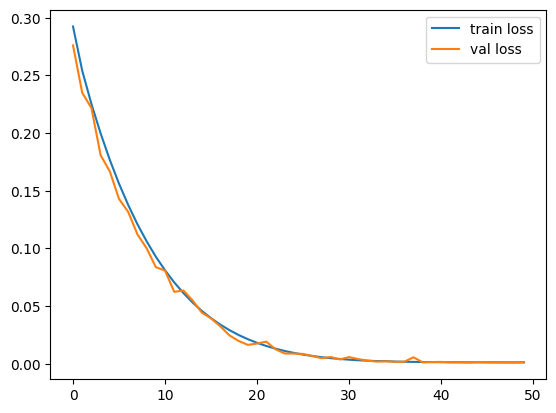

In [11]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.legend()

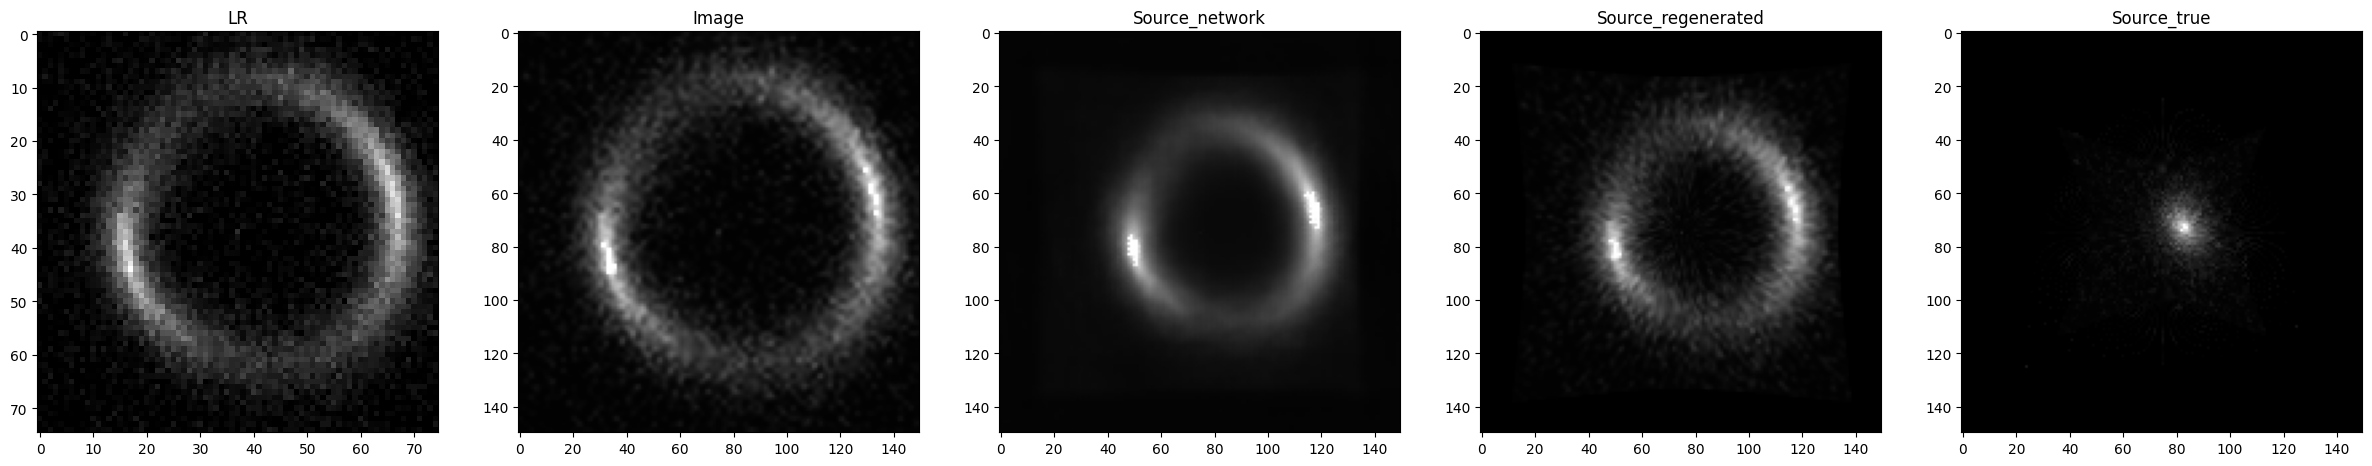

In [12]:
show_random_image(give_random_image(val_dataset, i_model, s_model, len(val_dataset)))